# Supervised learning

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
DATASET_DIR = "dataset" + os.sep
DATASET_NAME = "merge_clean_v2.csv"
ORIGINAL_DATASET_NAME = "races.csv"
ORIGINAL_CYCLIST_NAME = "cyclists.csv"
RESULTS_DIR = "results" + os.sep

In [3]:
dataset = pd.read_csv(DATASET_DIR + DATASET_NAME, parse_dates=["date"])
dataset = dataset.convert_dtypes()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589694 non-null  string        
 1   points             589694 non-null  Int64         
 2   length             589694 non-null  Float64       
 3   climb_total        442741 non-null  Int64         
 4   profile            475315 non-null  Int64         
 5   startlist_quality  589694 non-null  Int64         
 6   date               589694 non-null  datetime64[ns]
 7   position           589694 non-null  Int64         
 8   cyclist            589694 non-null  string        
 9   cyclist_age        589581 non-null  Int64         
 10  delta              589694 non-null  Int64         
 11  race               589694 non-null  string        
 12  year               589694 non-null  Int64         
 13  stage              589694 non-null  string  

In [4]:
old_dataset = pd.read_csv("./dataset/races.csv", parse_dates=["date"])

old_dataset.drop_duplicates(
    subset=old_dataset.columns.difference(["position"]), keep=False, inplace=True
)
old_dataset.drop_duplicates(subset=["_url", "cyclist"], keep="first", inplace=True)
old_dataset.reset_index(drop=True, inplace=True)
old_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   _url                 589694 non-null  object        
 1   name                 589694 non-null  object        
 2   points               589217 non-null  float64       
 3   uci_points           251085 non-null  float64       
 4   length               589694 non-null  float64       
 5   climb_total          442741 non-null  float64       
 6   profile              441642 non-null  float64       
 7   startlist_quality    589694 non-null  int64         
 8   average_temperature  29933 non-null   float64       
 9   date                 589694 non-null  datetime64[ns]
 10  position             589694 non-null  int64         
 11  cyclist              589694 non-null  object        
 12  cyclist_age          589581 non-null  float64       
 13  is_tarmac     

In [5]:
old_cyclist_df = pd.read_csv(DATASET_DIR + ORIGINAL_CYCLIST_NAME)
old_cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


In [6]:
dataset.set_index(["_url", "cyclist"], inplace=True)
old_dataset.set_index(["_url", "cyclist"], inplace=True)

# resetting columns that were imputed
dataset["profile"] = old_dataset["profile"]
dataset.reset_index(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589694 non-null  string        
 1   cyclist            589694 non-null  string        
 2   points             589694 non-null  Int64         
 3   length             589694 non-null  Float64       
 4   climb_total        442741 non-null  Int64         
 5   profile            441642 non-null  float64       
 6   startlist_quality  589694 non-null  Int64         
 7   date               589694 non-null  datetime64[ns]
 8   position           589694 non-null  Int64         
 9   cyclist_age        589581 non-null  Int64         
 10  delta              589694 non-null  Int64         
 11  race               589694 non-null  string        
 12  year               589694 non-null  Int64         
 13  stage              589694 non-null  string  

In [7]:
dataset = dataset.merge(
    old_cyclist_df,
    left_on="cyclist",
    right_on="_url",
    how="inner",
    suffixes=("", "_old"),
)

dataset["height"] = dataset["height_old"]
dataset["BMI"] = dataset["weight"] / (dataset["height"] / 100) ** 2

dataset = dataset[dataset.columns.drop(list(dataset.filter(regex="_old")))]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589694 non-null  string        
 1   cyclist            589694 non-null  object        
 2   points             589694 non-null  Int64         
 3   length             589694 non-null  Float64       
 4   climb_total        442741 non-null  Int64         
 5   profile            441642 non-null  float64       
 6   startlist_quality  589694 non-null  Int64         
 7   date               589694 non-null  datetime64[ns]
 8   position           589694 non-null  Int64         
 9   cyclist_age        589581 non-null  Int64         
 10  delta              589694 non-null  Int64         
 11  race               589694 non-null  string        
 12  year               589694 non-null  Int64         
 13  stage              589694 non-null  string  

In [8]:
dataset = (
    dataset.drop(columns=["nationality", "birth_year", "delta"])
    .select_dtypes(include=["number", "bool"])
    .assign(season=dataset["season"], continent=dataset["continent"])
)
dataset["continent"] = dataset["continent"].astype("category").cat.codes
dataset["season"] = dataset["season"].astype("category").cat.codes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   points             589694 non-null  Int64  
 1   length             589694 non-null  Float64
 2   climb_total        442741 non-null  Int64  
 3   profile            441642 non-null  float64
 4   startlist_quality  589694 non-null  Int64  
 5   position           589694 non-null  Int64  
 6   cyclist_age        589581 non-null  Int64  
 7   year               589694 non-null  Int64  
 8   height             479675 non-null  float64
 9   BMI                478052 non-null  float64
 10  weight             478362 non-null  float64
 11  season             589694 non-null  int8   
 12  continent          589694 non-null  int8   
dtypes: Float64(1), Int64(6), float64(4), int8(2)
memory usage: 54.6 MB


In [9]:
df_test = dataset.loc[dataset.year >= 2022].copy()
df_train = dataset.loc[dataset.year < 2022].copy()
assert len(df_test) + len(df_train) == len(dataset)

df_train.drop(columns=["year"], inplace=True)
df_test.drop(columns=["year"], inplace=True)

y_train = df_train.pop("position").apply(lambda x: 1 if x < 20 else 0)
y_test = df_test.pop("position").apply(lambda x: 1 if x < 20 else 0)

X_train = df_train
X_test = df_test

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((554288, 11), (554288,), (35406, 11), (35406,))

<Axes: >

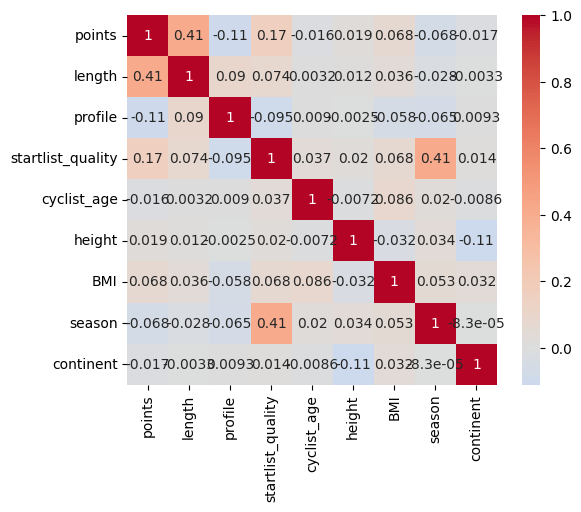

In [11]:
corr = X_train.drop(columns=["climb_total", "weight"]).corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, square=True)

In [12]:
nan_columns = X_train.columns[X_train.isna().any()].tolist()
print("Columns containing NaN values:", nan_columns)

Columns containing NaN values: ['climb_total', 'profile', 'cyclist_age', 'height', 'BMI', 'weight']


# Baseline (linear kernel SVM)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.impute import KNNImputer, SimpleImputer
from libraries.supervision import ColumnRemoverTransformer, BMICalculatorTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.utils import shuffle

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554288 entries, 0 to 589693
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   points             554288 non-null  Int64  
 1   length             554288 non-null  Float64
 2   climb_total        407335 non-null  Int64  
 3   profile            406236 non-null  float64
 4   startlist_quality  554288 non-null  Int64  
 5   cyclist_age        554175 non-null  Int64  
 6   height             444688 non-null  float64
 7   BMI                443522 non-null  float64
 8   weight             443764 non-null  float64
 9   season             554288 non-null  int8   
 10  continent          554288 non-null  int8   
dtypes: Float64(1), Int64(4), float64(4), int8(2)
memory usage: 46.0 MB


In [15]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [62]:
N_NEIGHBORS = 5
FOLDS = 5
OUT_NAME = "svm-linear-newprof-rund.csv"

In [63]:
param_grid = {
    "classifier__C": [10**i for i in range(-5, 2, 1)],
    "classifier__class_weight": [
        "balanced",
    ],
}
print(param_grid)

{'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'classifier__class_weight': ['balanced']}


In [64]:
# define imputer for imputation
profile_imputer = SimpleImputer(strategy="constant", fill_value=0).set_output(
    transform="pandas"
)
general_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

# define sampler for sampling
# sampler = RandomOverSampler(random_state=42, sampling_strategy="minority")
sampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")

preprocessor = ColumnTransformer(
    transformers=[
        (
            "general",
            general_imputer,
            ["cyclist_age", "height", "weight"],
        ),
        ("profile", profile_imputer, ["profile"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

encoder = ColumnTransformer(
    transformers=[
        (
            "scaler",
            StandardScaler(),
            ["points", "height", "BMI", "cyclist_age", "length", "startlist_quality"],
        ),
        ("onehot", OneHotEncoder(), ["profile", "season", "continent"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

clf = LinearSVC(random_state=42, max_iter=10000, class_weight="balanced")

# Create the pipeline
clf_pipeline = Pipeline(
    steps=[
        ("sampling", sampler),
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total"])),
        ("encoder", encoder),
        ("classifier", clf),
    ]
)

In [65]:
# initialize grid search
grid_search = GridSearchCV(
    clf_pipeline,
    param_grid=param_grid,
    cv=5,
    refit="precision",
    n_jobs=-1,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    verbose=3,
)

# start the training
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END classifier__C=1e-05, classifier__class_weight=balanced; accuracy: (test=0.592) f1: (test=0.317) precision: (test=0.218) recall: (test=0.586) roc_auc: (test=0.625) total time=   0.9s
[CV 2/5] END classifier__C=1e-05, classifier__class_weight=balanced; accuracy: (test=0.592) f1: (test=0.315) precision: (test=0.216) recall: (test=0.579) roc_auc: (test=0.622) total time=   1.0s
[CV 3/5] END classifier__C=1e-05, classifier__class_weight=balanced; accuracy: (test=0.590) f1: (test=0.318) precision: (test=0.218) recall: (test=0.589) roc_auc: (test=0.623) total time=   1.0s
[CV 5/5] END classifier__C=1e-05, classifier__class_weight=balanced; accuracy: (test=0.594) f1: (test=0.319) precision: (test=0.219) recall: (test=0.587) roc_auc: (test=0.624) total time=   0.9s
[CV 4/5] END classifier__C=1e-05, classifier__class_weight=balanced; accuracy: (test=0.586) f1: (test=0.314) precision: (test=0.215) recall: (test=0.584) roc_au

/Users/saulurso/Documents/Notebooks/DM/Data-Mining/venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy='majority')),
                                       ('imputation',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('general',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['cyclist_age',
                                                                          'height',
                                                                          'weight']),
                                                                        ('profile',
                                                                         SimpleImputer(fill_value=0,
                                                                                       strategy='constant'),
                                                                         ['profile'])],
                                                          verbos...
                                                                         ['profile',
                                                                          'season',
                                                                          'continent'])],
                                                          verbose_feature_names_out=False)),
                                       ('classifier',
                                        LinearSVC(class_weight='balanced',
                                                  max_iter=10000,
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                           10],
                         'classifier__class_weight': ['balanced']},
             refit='precision',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=3)

In [66]:
cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
cv_results.to_csv(RESULTS_DIR + OUT_NAME, index=False)

In [67]:
cv_results[
    [
        "params",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_f1",
        "mean_test_roc_auc",
    ]
]

,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,"{'classifier__C': 1e-05, 'classifier__class_we...",0.590751,0.217103,0.584697,0.316634,0.623150
1,"{'classifier__C': 0.0001, 'classifier__class_w...",0.635769,0.229663,0.529312,0.320328,0.625486
2,"{'classifier__C': 0.001, 'classifier__class_we...",0.644986,0.232746,0.517852,0.321143,0.625914
3,"{'classifier__C': 0.01, 'classifier__class_wei...",0.645722,0.232967,0.516795,0.321150,0.625995
4,"{'classifier__C': 0.1, 'classifier__class_weig...",0.645796,0.233018,0.516806,0.321200,0.626004
5,"{'classifier__C': 1, 'classifier__class_weight...",0.645801,0.233021,0.516806,0.321204,0.626006
6,"{'classifier__C': 10, 'classifier__class_weigh...",0.645800,0.233018,0.516795,0.321198,0.626006
